In [1]:
import requests
import json

# Define the URL of the API endpoint
url = "https://dfwsa.deepflow.in/api/data/list/?limit=20000"

# Send a GET request to the API endpoint
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # If successful, you can access the data from the response
    api_data = response.json()

    # Extract specific fields
    selected_data = {key: api_data[key] for key in ["count", "next", "previous", "results"]}

    # Do something with the selected data, such as saving it to a file
    with open("weather_data_tata_selected.json", "w") as file:
        file.write(json.dumps(selected_data))

    print("Selected data downloaded successfully.")
else:
    # If the request was unsuccessful, print an error message
    print("Error:", response.status_code)


Selected data downloaded successfully.


In [13]:
import json
import pandas as pd

# Load the weather data from the JSON file
with open('weather_data_tata_selected.json', 'r') as f:
    data_str = f.read()

# Convert the JSON string to a Python object
data = json.loads(data_str)

# Extract 'results' from the data
weather_data = data.get('results', [])

# Create a list of dictionaries where each dictionary represents a data point
data_list = []
for entry in weather_data:
    data_point = {
        'Timestamp': entry.get('time'),
        'rainfall': entry.get('rainfall'),
        'temperature': entry.get('temperature'),
        'pressure': entry.get('pressure'),
        'Direction': entry.get('direction'),
        'humidity': entry.get('humidity'),
        'speed': entry.get('speed'),
        'lux': entry.get('lux'),
        'Angle': entry.get('angle')
    }
    data_list.append(data_point)

# Create a DataFrame from the list of dictionaries
df = pd.DataFrame(data_list)
# Reverse the order of rows
df = df[::-1].reset_index(drop=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Timestamp')

# Filter data from 5 PM, 22nd February onwards
start_time = pd.Timestamp('2024-02-23 06:21:00')
df_filtered = df[df.index >= start_time]

# Display the filtered DataFrame
df = df_filtered.copy()
df

,rainfall,temperature,pressure,Direction,humidity,speed,lux,Angle
Timestamp,,,,,,,,
2024-02-23 06:21:51.601212,0.0,17.80,904.24,13.0,71.29,0.0,0.92,286.4
2024-02-23 06:21:52.761415,0.0,18.03,904.23,13.0,71.11,0.0,0.92,286.9
2024-02-23 06:21:54.582181,0.0,18.05,904.28,13.0,70.58,0.0,0.92,285.4
2024-02-23 06:21:56.421437,0.0,18.07,904.27,13.0,69.63,0.0,0.92,284.9
2024-02-23 06:21:58.141304,0.0,18.08,904.27,13.0,69.57,0.0,0.92,285.4
...,...,...,...,...,...,...,...,...
2024-02-28 14:19:50.928042,0.0,32.98,901.58,5.0,24.51,0.8,22240.97,104.9
2024-02-28 14:19:52.688802,0.0,32.98,901.59,4.0,24.52,1.0,22213.32,97.2
2024-02-28 14:19:54.507694,0.0,32.98,901.57,4.0,24.37,1.4,22244.66,96.6


<Axes: xlabel='Timestamp'>

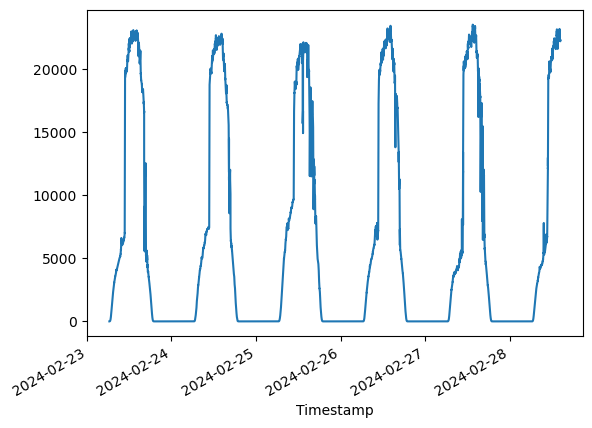

In [3]:
df.lux.plot()

In [4]:
import pandas as pd

# Assuming your data is in a DataFrame named 'df' with the 'Timestamp' as the index
# and 'lux' column for light intensity

# Convert the index to datetime
df.index = pd.to_datetime(df.index)

# Calculate time differences
df['time_diff'] = df.index.to_series().diff()

# Function to get the total light duration for a day
def get_light_duration(group):
    light_mask = group['lux'] > 1
    group['light_duration'] = group['time_diff'].where(light_mask, pd.Timedelta(0)).cumsum()
    return group['light_duration'].iloc[-1]

# Function to get the total day duration for a day
def get_total_duration(group):
    group['total_duration'] = group['time_diff'].cumsum()
    return group['total_duration'].iloc[-1]

# Group by date and apply the functions
daily_light_duration = df.groupby(df.index.date).apply(get_light_duration)
daily_total_duration = df.groupby(df.index.date).apply(get_total_duration)

# Calculate the duration of no light
daily_no_light_duration = daily_total_duration - daily_light_duration

# Print the results
result_df = pd.DataFrame({
    'Date': daily_light_duration.index,
    'Light_Duration': daily_light_duration.dt.total_seconds() / 3600,  # Convert to hours
    'No_Light_Duration': daily_no_light_duration.dt.total_seconds() / 3600  # Convert to hours
}).reset_index(drop=True)  # Reset index to remove duplicate date column

def bold_style(val):
    return 'font-weight: bold'

# Apply bold style to the DataFrame
styled_df = result_df.style.applymap(bold_style, subset=pd.IndexSlice[:, ['Date', 'Light_Duration', 'No_Light_Duration']])

# Display the styled DataFrame
styled_df

,Date,Light_Duration,No_Light_Duration
0,2024-02-23,12.521536,5.098932
1,2024-02-24,12.521350,11.457864
2,2024-02-25,12.627658,11.351830
3,2024-02-26,12.627180,11.352930
4,2024-02-27,12.627280,11.352338
5,2024-02-28,8.063999,6.365567


# Weekly Trend {min and max}

In [7]:
df.drop(columns=['time_diff'], inplace=True)

In [8]:
from IPython.display import display, HTML
min_values = df.min()
max_values = df.max()
result = pd.concat([min_values, max_values], axis=1)
result.columns = ['Min', 'Max']

# Convert to HTML to include bold formatting
result_html = result.to_html().replace('<td>', '<td style="font-weight:bold">')

# Display the HTML-formatted result in the notebook
display(HTML(result_html))


,Min,Max
rainfall,0.00,0.00
temperature,16.80,34.86
pressure,899.72,906.25
Direction,0.00,16.00
humidity,23.67,100.00
speed,0.00,3.80
lux,0.00,23530.75
Angle,0.50,360.00


# Daliy Trend {min and max}

In [9]:
import pandas as pd

# Assuming your DataFrame is named 'df' and the Timestamp column is set as the index
# If not, you can set it using df.set_index('Timestamp', inplace=True)

# Convert the Timestamp to the date only
df.index = pd.to_datetime(df.index).date

# Group by date and find min and max for each column
min_values = df.groupby(df.index).min()
max_values = df.groupby(df.index).max()

# Display the results in bold and DataFrame format
print("\033[1mMinimum values:\033[0m")
pd.DataFrame(min_values)

Minimum values:


,rainfall,temperature,pressure,Direction,humidity,speed,lux,Angle
2024-02-23,0.0,17.80,901.25,1.0,24.89,0.0,0.0,26.2
2024-02-24,0.0,16.80,901.54,0.0,32.07,0.0,0.0,9.2
2024-02-25,0.0,17.78,899.72,0.0,28.98,0.0,0.0,1.0
2024-02-26,0.0,17.99,900.62,0.0,25.86,0.0,0.0,2.0
2024-02-27,0.0,17.07,901.34,0.0,32.21,0.0,0.0,0.5
2024-02-28,0.0,17.62,901.55,0.0,23.67,0.0,0.0,0.5


In [10]:
print("\n\033[1mMaximum values:\033[0m")
pd.DataFrame(max_values)


Maximum values:


,rainfall,temperature,pressure,Direction,humidity,speed,lux,Angle
2024-02-23,0.0,34.77,906.25,14.0,92.42,3.1,23097.60,320.4
2024-02-24,0.0,33.18,905.80,16.0,98.31,2.1,22814.67,360.0
2024-02-25,0.0,34.86,905.09,16.0,100.00,3.1,22133.14,356.4
2024-02-26,0.0,32.21,905.22,16.0,95.41,3.8,23441.36,360.0
2024-02-27,0.0,33.62,905.74,16.0,94.39,3.8,23530.75,360.0
2024-02-28,0.0,33.70,905.53,16.0,94.75,3.3,23192.06,360.0


# min and max plot with daily trend

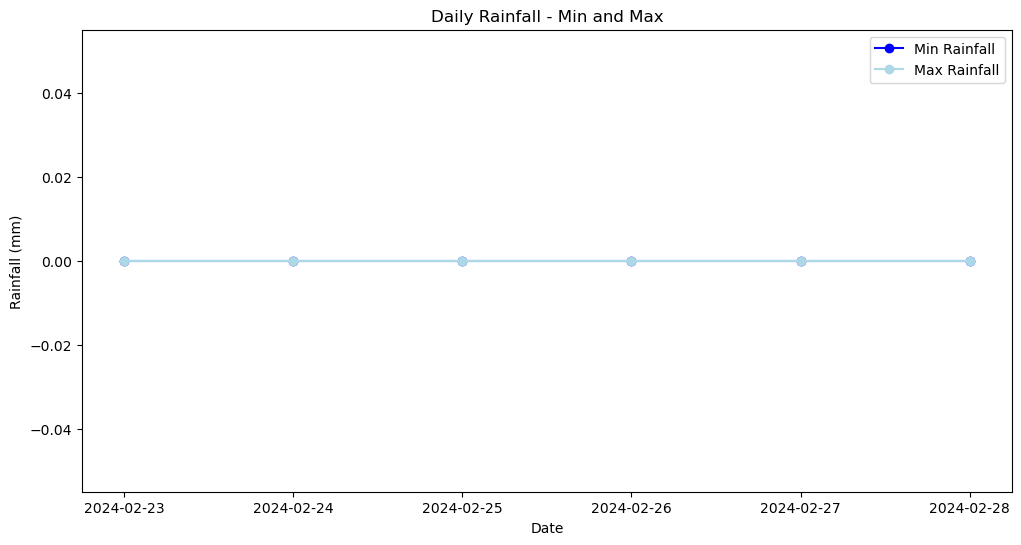

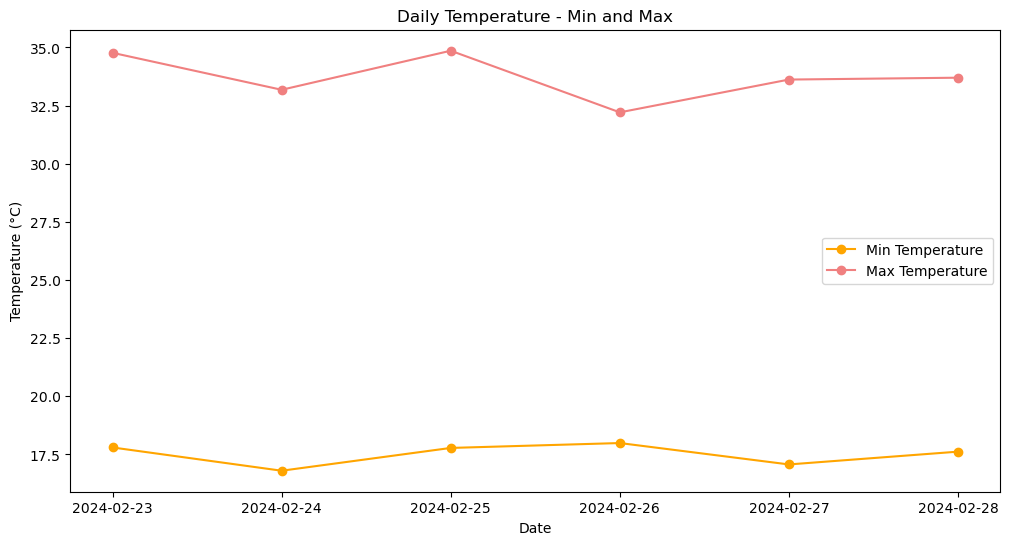

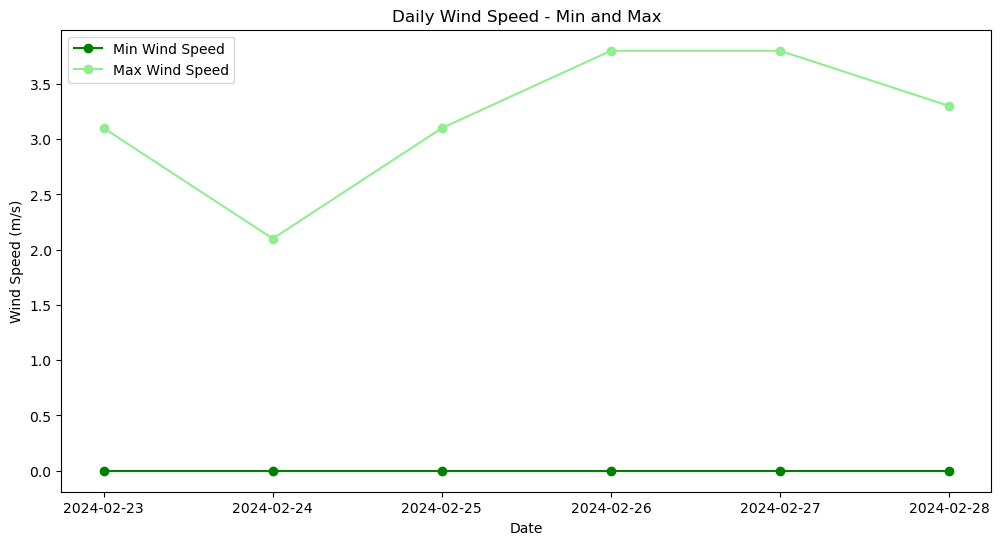

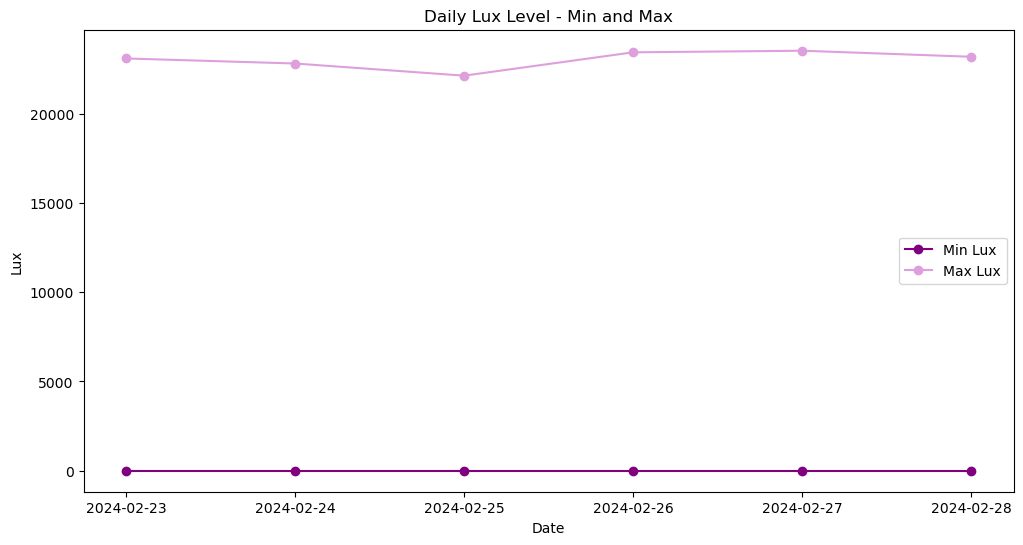

In [11]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df' and the Timestamp column is set as the index
# If not, you can set it using df.set_index('Timestamp', inplace=True)

# Convert the Timestamp to the date only
df.index = pd.to_datetime(df.index).date

# Group by date and find min and max for each column
min_values = df.groupby(df.index).min()
max_values = df.groupby(df.index).max()

# Plotting for Rainfall
plt.figure(figsize=(12, 6))
plt.plot(min_values.index, min_values['rainfall'], label='Min Rainfall', color='blue', marker='o')
plt.plot(max_values.index, max_values['rainfall'], label='Max Rainfall', color='lightblue', marker='o')
plt.title('Daily Rainfall - Min and Max')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.show()

# Plotting for Temperature
plt.figure(figsize=(12, 6))
plt.plot(min_values.index, min_values['temperature'], label='Min Temperature', color='orange', marker='o')
plt.plot(max_values.index, max_values['temperature'], label='Max Temperature', color='lightcoral', marker='o')
plt.title('Daily Temperature - Min and Max')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

# Plotting for Speed
plt.figure(figsize=(12, 6))
plt.plot(min_values.index, min_values['speed'], label='Min Wind Speed', color='green', marker='o')
plt.plot(max_values.index, max_values['speed'], label='Max Wind Speed', color='lightgreen', marker='o')
plt.title('Daily Wind Speed - Min and Max')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.legend()
plt.show()

# Plotting for Lux
plt.figure(figsize=(12, 6))
plt.plot(min_values.index, min_values['lux'], label='Min Lux', color='purple', marker='o')
plt.plot(max_values.index, max_values['lux'], label='Max Lux', color='plum', marker='o')
plt.title('Daily Lux Level - Min and Max')
plt.xlabel('Date')
plt.ylabel('Lux')
plt.legend()
plt.show()

# plotting all the data

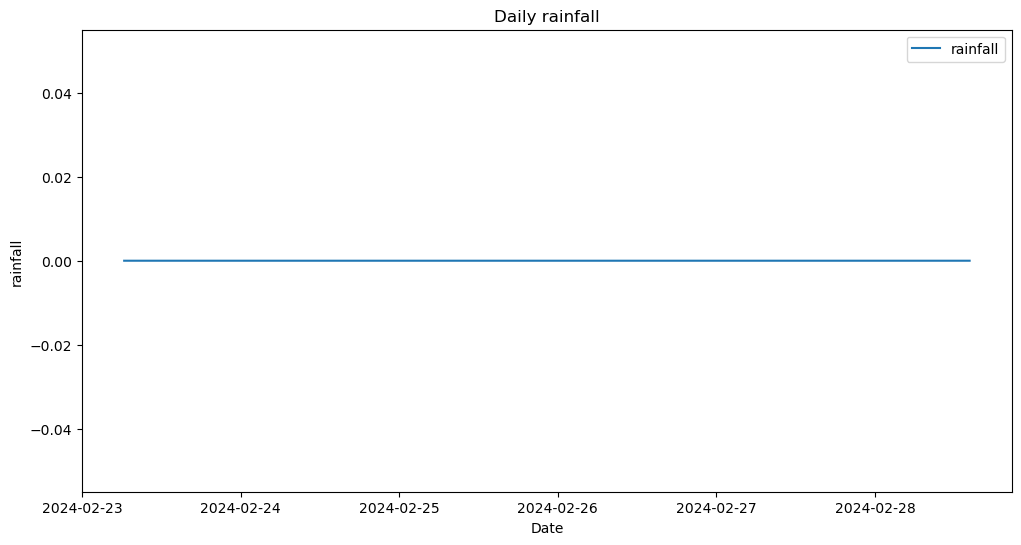

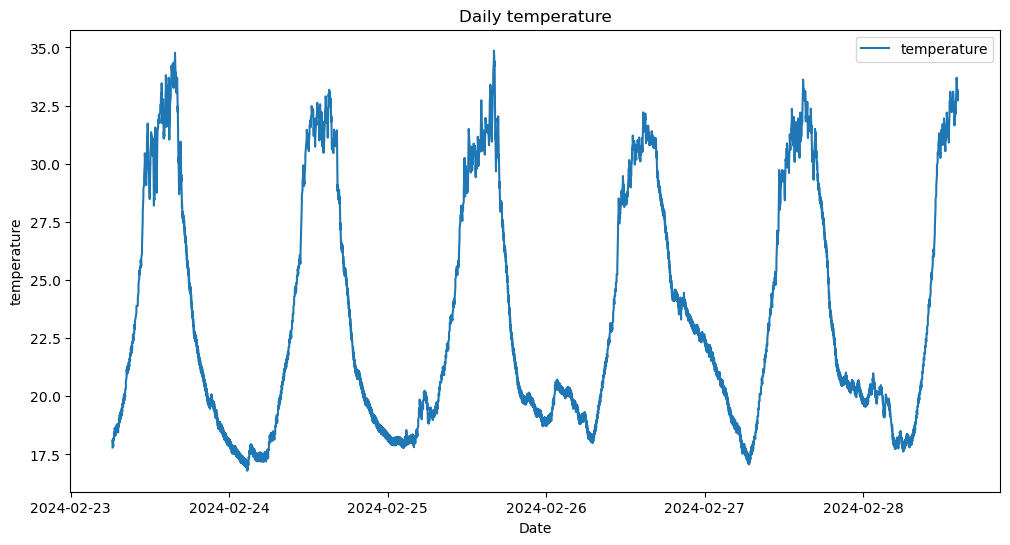

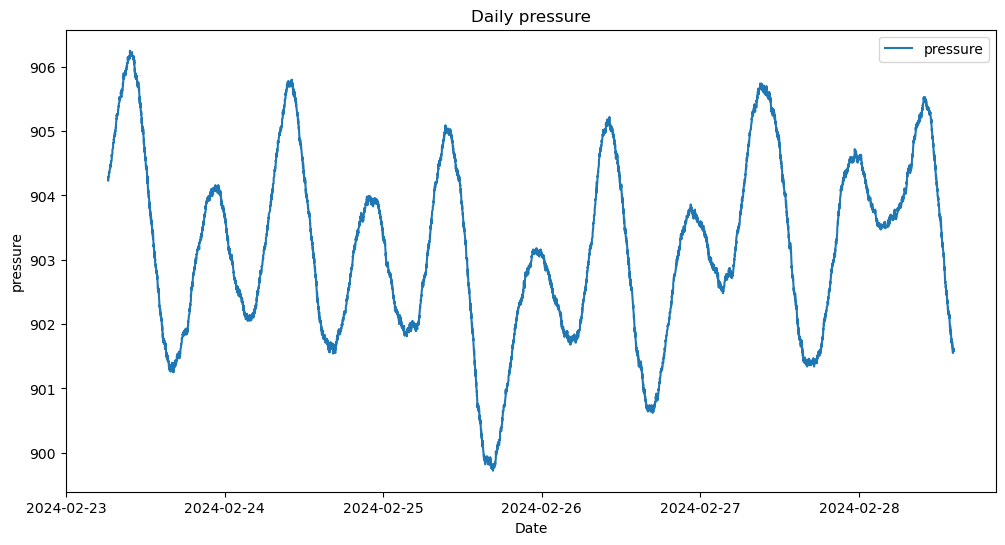

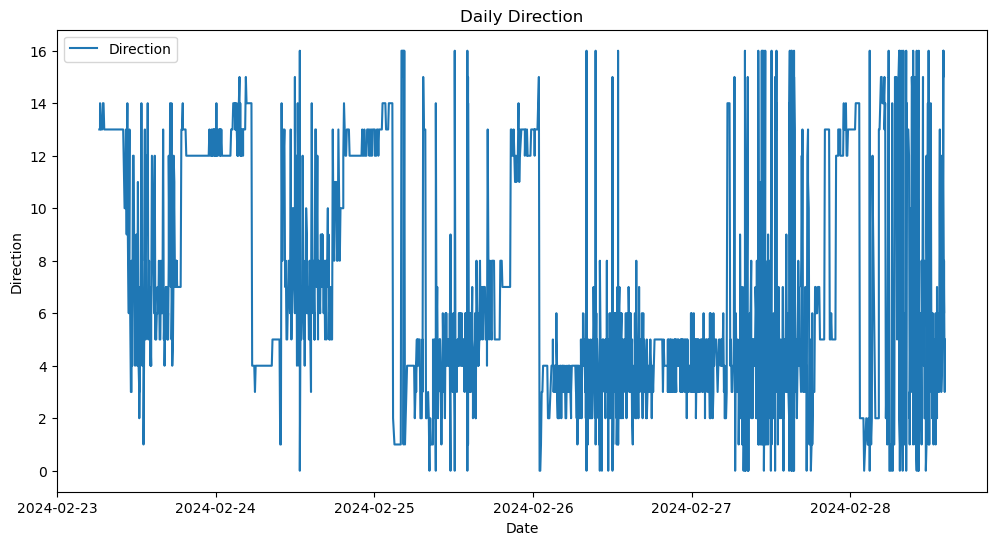

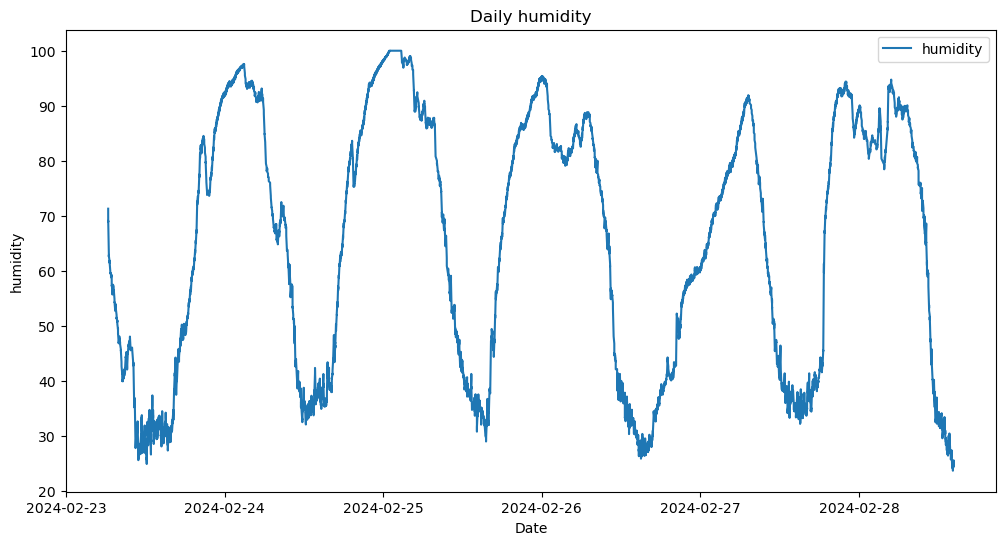

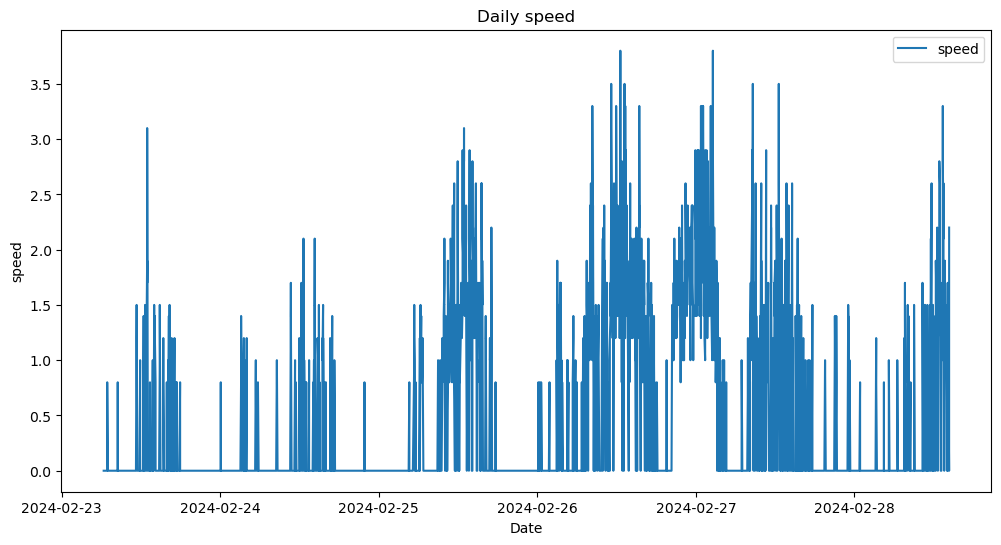

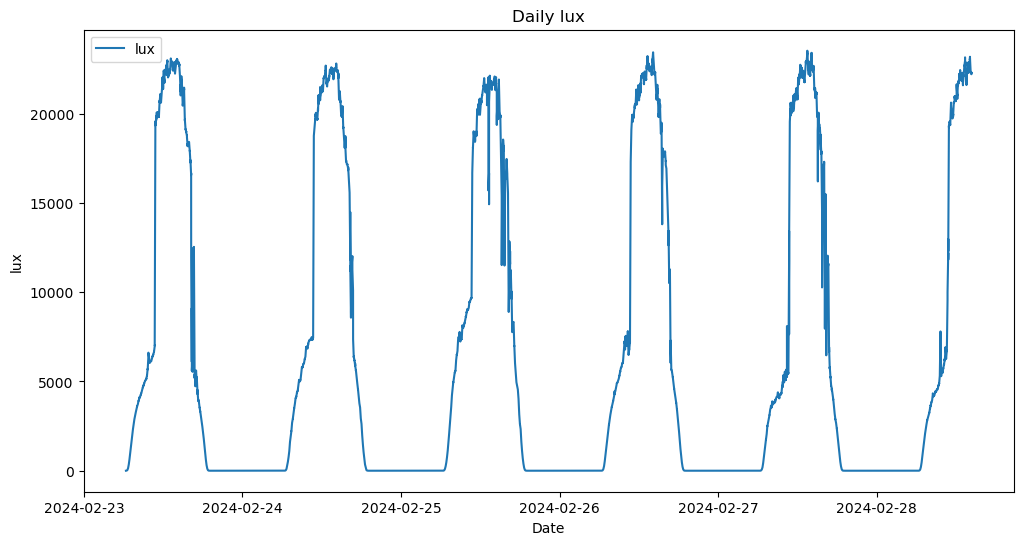

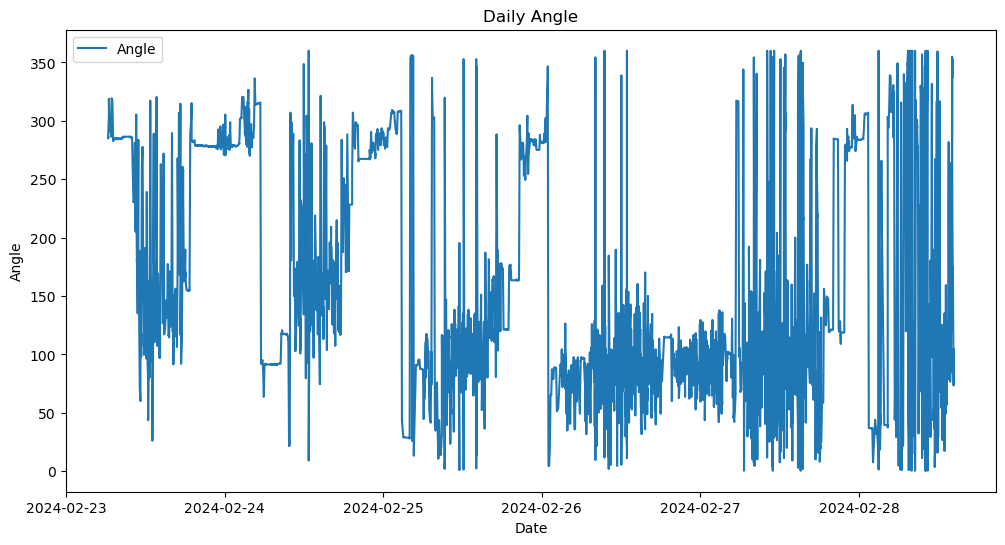

In [14]:
# Assuming your DataFrame is named 'df' and the Timestamp column is set as the index
# If not, you can set it using df.set_index('Timestamp', inplace=True)



# Plotting for each column in separate figures
columns_to_plot = ['rainfall', 'temperature', 'pressure', 'Direction', 'humidity', 'speed', 'lux', 'Angle']

for column in columns_to_plot:
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[column], label=column)
    plt.title(f'Daily {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.show()
